
RMSE on Test Set (Reconstructed): 9.15


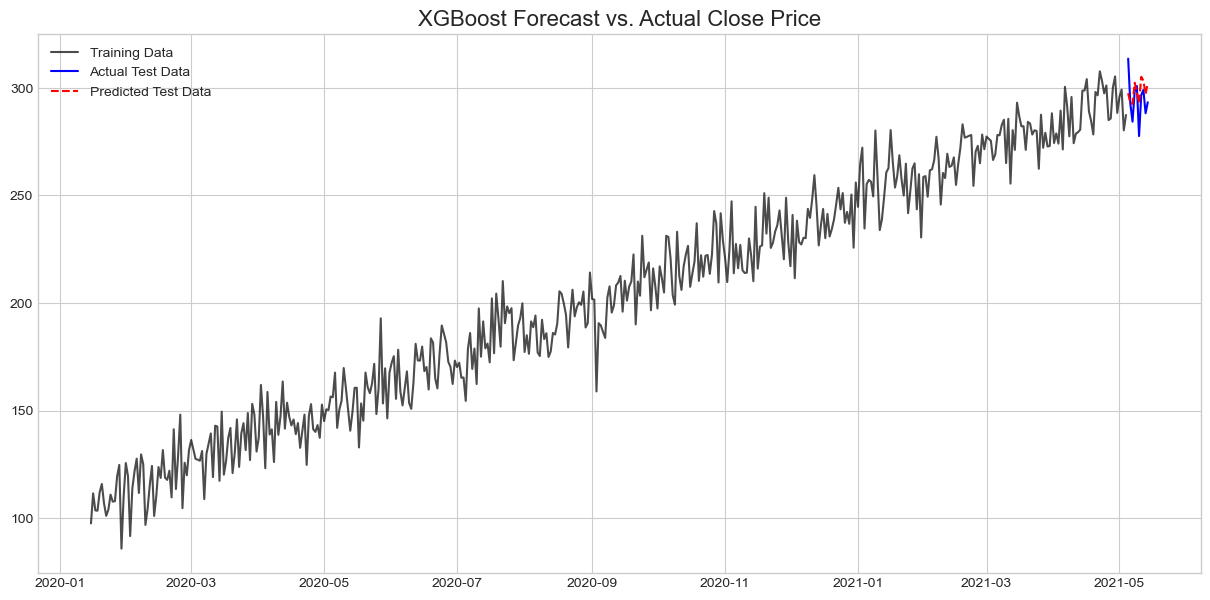

In [57]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- 1. Load and Prepare Data ---
# Using sample data. Replace with your actual data loading.
data = {'Date': pd.to_datetime(pd.date_range(start='2020-01-01', periods=500, freq='D')),
        'Close': np.linspace(100, 300, 500) + np.random.randn(500) * 10}
df = pd.DataFrame(data)
df = df.set_index('Date')

# --- 2. Feature Engineering ---
# Basic time-based features
df['month'] = df.index.month
df['year'] = df.index.year

# Lag and rolling mean features
n_lags = 7
for i in range(1, n_lags + 1):
    df[f'lag_{i}'] = df['Close'].shift(i)

rolling_windows = [7, 14]
for window in rolling_windows:
    df[f'rolling_mean_{window}'] = df['Close'].rolling(window=window).mean().shift(1)

# Advanced features
df['rolling_std_7'] = df['Close'].rolling(window=7).std().shift(1)
df['momentum_5'] = df['Close'].diff(5).shift(1)


# --- 3. Create Differenced Target Variable ---
df['target'] = df['Close'].diff()
df.dropna(inplace=True)

# --- 4. Define Features (X) and Target (y) ---
y = df['target']
X = df.drop(['Close', 'target'], axis=1)

# --- 5. Split, Train, Predict, Reconstruct ---
# --- CHANGE FOR ARIMA COMPARISON ---
# Set test size to 10 to match the ARIMA model
test_size = 10
# --- END CHANGE ---

X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

reg = xgb.XGBRegressor(
    n_estimators=1000, max_depth=5, learning_rate=0.01,
    objective='reg:squarederror', early_stopping_rounds=10, n_jobs=-1, random_state=42 
)
reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

pred_diff = reg.predict(X_test)

last_known_price = df['Close'].iloc[-test_size - 1]
reconstructed_forecast = last_known_price + np.cumsum(pred_diff)

# --- 6. Evaluate and Visualize ---
actual_prices = df['Close'].iloc[-test_size:]
rmse = np.sqrt(mean_squared_error(actual_prices, reconstructed_forecast))
print(f"\nRMSE on Test Set (Reconstructed): {rmse:.2f}")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df['Close'].iloc[:-test_size], label='Training Data', color='black', alpha=0.7)
ax.plot(actual_prices.index, actual_prices, label='Actual Test Data', color='blue')
ax.plot(actual_prices.index, reconstructed_forecast, label='Predicted Test Data', color='red', linestyle='--')
ax.set_title('XGBoost Forecast vs. Actual Close Price', fontsize=16)
ax.legend()
plt.show()